#  MA5851: DATA SCIENCE MASTERCLASS 1
## A3: WebCrawler and NLP System 
### D3: Prototype NLP

The objective of the following prototype is to take the web harvested metadata and extract features and attributes in support of identifying critical success factors for designing Grimdark novel descriptions.

The central variable driving this process is the “descriptions” scraped and supplemented on 1,019 grimdark novels, as classified by a community of independent readers. With the broad methodology being to:

    1) Pre-process (expose the text descriptions to NLP pre-processing to remove any noise), 

    2) Extract Keywords (filter keywords from the text to improve the accuracy of further NLP processes), and

    3) Analyse Sentiment (extract the blend of sentiment used by each Grimdark description identified).

With the results of both the keyword extraction and sentiment analysis then explored, in contrast between high/low performing titles, to isolate the ingredients (keywords and mix of sentiment) for successful product promotion.

### <u>Natural Language Pre-processing</u>

Text pre-processing is described as the first and most important step to any NLP task, in order for any feature extraction or AI based tasks to operate effectively (Verma, 2020). According to Weng (2021), the broad phases involve tokenization, normalisation, and noise removal. However, Mayo (2020) describes it broadly as the process of taking a body of text and performing analysis and transformations to retain only those artefacts that are more useful for performing further, more meaningful analytical tasks later.

To conduct this and the following NLP processes, an array of python packages are required.

In [ ]:
# import the Required Packages
import pandas as pd
from bs4 import BeautifulSoup
import unidecode
from word2number import w2n
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import yake
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# import the harvested munged data
df = pd.read_csv('munged_df.csv')
# copy the description field as a new variable
df['desc_clean'] = df['description']

_<u>Step 1:</u>_ 

The first pre-processing step taken ensured any text relics of the web scraping process were removed using the html.parser functionality from the BeautifulSoup library.

In [ ]:
# A) remove HTML tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
df['desc_clean'] = df['desc_clean'].apply(strip_html_tags)

_<u>Step 2:</u>_

Which was followed by transforming any accented words (e.g., like “latté” or “café”) to standard spelling using the unidecode library, since “latté” and “latte” will be treated as unique tokens during future processes.

In [ ]:
# B) remove accented characters
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text
df['desc_clean'] = df['desc_clean'].apply(remove_accented_chars)

_<u>Step 3:</u>_

The third step in the process being the universal lower casing of all text, which is ubiquitous for any NLP tasks.

In [ ]:
# C) lowercase all texts
def lower_case(text):
    return str(text).lower()
df['desc_clean'] = df['desc_clean'].apply(lower_case)

_<u>Step 4:</u>_

However, the fourth step, which is an inbuilt process in some black box functions, is the expanding of contractions (e.g., “ don’t” to “do not”). Performed using functions from the contractions library, this phase is an extra step taken to ensure further pre-processing steps don’t overlook such tokens as unrecognisable.

In [ ]:
# D) expand contractions
def expand_contractions(text):
    text = contractions.fix(text)
    return text
df['desc_clean'] = df['desc_clean'].apply(expand_contractions)

_<u>Step 5:</u>_

This was followed by the exclusion of non-alphanumeric text using the defined function below.

In [ ]:
# E) remove special characters (i.e., non-alphanumeric)
def irrelevant_characters(text):
    return re.sub('[^A-Za-z0-9 ]+', ' ', text)
df['desc_clean'] = df['desc_clean'].apply(irrelevant_characters)

_<u>Step 6:</u>_

Which was followed by the first of two steps used to exclude numbers from the analysis. With the following function applying the word2number library functionality in converting all number words to their numeric form.

In [ ]:
# F) convert number words to numeric form
def text_to_numeric(text):
    s = text.split()
    o = []
    for word in s:
        try:
            o += [str(w2n.word_to_num(word))]
        except ValueError:
            o += [word]
    text_numeric = (' '.join(o))
    return text_numeric
df['desc_clean'] = df['desc_clean'].apply(text_to_numeric)

_<u>Step 7:</u>_

After which all numbers were removed from the corpus using an inline application of the isdigit function.

In [ ]:
# G) remove numbers
def remove_numbers(text):
    new_text = "".join(filter(lambda x: not x.isdigit(), text))
    return new_text
df['desc_clean'] = df['desc_clean'].apply(remove_numbers)

_<u>Step 8:</u>_

And finally, with just alphabet characters and white space remaining, any excessive white spaces were excluded using the split function.

In [ ]:
# H) remove extra whitespaces
def remove_whitespace(text):
    text = text.strip()
    return " ".join(text.split())
df['desc_clean'] = df['desc_clean'].apply(remove_whitespace)

_<u>Step 9:</u>_

Which brings us to the traditional starting point of pre-processing as Weng (2021) described it. With the following function tokenizing all words still remaining after the previous phases of pre-processing. This is done using the nltk libraries word_tokenize function.

In [ ]:
# I) tokenization
def make_tokens(text):
    return word_tokenize(text)
df['desc_clean'] = df['desc_clean'].apply(make_tokens)

_<u>Step 10:</u>_

Once tokenized, we remove any that match with a maintained list of English stopwords, available in the nltk library.

In [ ]:
# J) remove Stopwords
stop_words = set(stopwords.words('english'))
def clean_stopwords(token):
    return [item for item in token if item not in stop_words]
df['desc_clean'] = df['desc_clean'].apply(clean_stopwords)

_<u>Step 11:</u>_

However, the eleventh phase makes use of the WordNetLemmatizer, which is a large database of English nouns, verbs, adjectives and adverbs, that are grouped into sets of synonyms expressing a distinct concept. This extensive lexicon allows us to reduce the inflectional forms of each word into a normalised base (i.e., it takes each token and returns the lemma or root word). The following function applied the lemmatization process to each of the 1,019 tokenized clean descriptions in our data frame.

In [ ]:
# K) lemmatization
lemma = WordNetLemmatizer()
def clean_lemmatization(token):
    return [lemma.lemmatize(word=w, pos='v') for w in token]
df['desc_clean'] = df['desc_clean'].apply(clean_lemmatization)

_<u>Step 12:</u>_

While the last two phases simply excluded any short non-descript words and converted the tokens back to strings.

In [ ]:
# L) remove the words having length <= 3
def clean_length(token):
    return [i for i in token if len(i) > 3]
df['desc_clean'] = df['desc_clean'].apply(clean_length)

# M) convert the list of tokens into back to the string
def convert_to_string(listReview):
    return " ".join(listReview)
df['desc_clean'] = df['desc_clean'].apply(convert_to_string)

At this stage, with pre-processing complete, the clean text is deemed suitable to be applied to its first NLP phase in keyword extraction.

### <u>Keyword Extraction with Yake</u>

Yet Another Keyword Extractor (Yake) is an unsupervised method of keyword extraction that uses text features.  Described by Campos, Mangaravite, Pasquali, Jorge, Nunes and Jatowt (2018) as a text feature based automatic keyword identification system, this lightweight (lexicon, thesaurus, and training corpus free) extraction and ranking approach isolates keywords from any document. Their paper also benchmarks Yake against both unsupervised (TF.IDF, KP-Miner, RAKE, TextRank, SingleRank, ExpandRank, TopicRank, TopicalPageRank, PositionRank and MultipartiteRank), and supervised (KEA) approaches, using 20 datasets to show how much it outperforms the competition.

According to Shrivastava (2020), behind the curtain such performance is achieved with a 5-step process:

> 1.	Text Pre-processing and candidate term identification
>
> Using the python segtok library, a document is broken into sentences, then chunks, then tokens which are converted to lowercase and flagged with rule-based delimiters for later identification.
>
>
> 2.	Feature Extraction
>
> Here various statistics (term frequency, index of terms, term frequency of acronyms and upper-case terms, captured to generate a co-occurrence matrix) are calculated to extract very specific features (i.e., Casing, Term Position, Normalization, Term To Context and Term Different Sentence). With term frequency and TF Normalization identified as most important to the model performance during development.
>
>
> 3.	Computing Term Score
>
> Once all the features are extracted the final term score is calculated.
>
>
> 4.	N-gram generation and computing candidate keyword score
>
> Then a sliding window of n-gram specified size generates contiguous sequences of words, with ngrams formed where a sequency belongs to the same previously identified chunk, but only where the ngram does not begin/end with any stopwords.
>
>
> 5.	Data deduplication and Ranking.
>
> And lastly, Levenshtein distance similarity is used to identify and remove potential duplicates based on the parameter threshold chosen.


According to Chaudhary (2020), the key benefit of the Yake method (besides simple implementation and performance) is its seamless ability to summarize the underlying theme(s) of any document with a reduced list of key terms. For this reason, alongside the ability to control an impressive list of parameters, Yake is the method of choice for this project. But then, why keyword extraction at all?

The reason keyword extraction was implemented in the first place is simply that the second NLP process in this prototype involves sentiment analysis, which Rao (2019) argues performs greatest against smaller corpus that are not drowned out by a large number of words. 

The chosen parameters and implementation of the Yake method (guided by the repo https://github.com/LIAAD/yake) are shown below.

In [ ]:
# specify the parameters
language = "en"                     # English language words only
max_ngram_size = 1                  # Single word max (instead of 2=bigram or 3=trigram)
deduplication_thresold = 0.1        # 0.1 (avoid repetition) to 0.9 (allow repetition)
deduplication_algo = 'seqm'         # Structural Edge Quality Metric (over leve or jaro)
windowSize = 1                      # Computing words left to right
numOfKeywords = 50                  # Number of words to be extracted

custom_kw_extractor = yake.KeywordExtractor(lan=language,
                                            n=max_ngram_size,
                                            dedupLim=deduplication_thresold,
                                            dedupFunc=deduplication_algo,
                                            windowsSize=windowSize,
                                            top=numOfKeywords,
                                            features=None)

# extract the keywords
df['desc_yake'] = df['desc_clean'].apply(custom_kw_extractor.extract_keywords)
# convert the list of tuples returned back to a string
df['desc_yake'] = df['desc_yake'].astype(str)
# replace non-alphabet characters with a blank space
df['desc_yake'] = df['desc_yake'].str.replace('[^a-zA-Z]', ' ')
# remove excessive white spaces
df['desc_yake'] = df['desc_yake'].apply(remove_whitespace)

With the selection of each hyper-parameters being based on the outcome sought, in support of the sentiment analysis to follow. The individual rationale for each parameter included:

- lan (only English language text descriptions were included in this process)
- n (we seek an output of individual already lemmatized thematic words, not ngrams)
- dedupLim (since we require individual words we want to avoid repetition)
- dedupFunc (Structural Edge Quality Metric returned greater results than Levenshtein or Jaro)
- windowSize (left to right calculation is suitable to unstructured English language text)
- top (50 keywords max extraction was chosen since this mirrors the average size of tweets, which Vader was trained on).

The outcome of this process was a successful reduction in corpus to a quarter of it's original size (i.e., from an average of 848 characters per title to 308). Allowing the subsequent sentiment analysis to find greater polarity among themes.

### <u>Sentiment Analysis with Vader</u>

Sentiment analysis is the process of computationally identifying whether text is positive, negative, or neutral, with the majority of approaches being either polarity-based (texts is classified as positive or negative), or valence-based (where the intensity sentiment is determined) (Burchell, 2017). However, the Valence Aware Dictionary and sEntiment Reasoner (Vader) approach has been described as a combination of both. 

Pandey (2020) describes Vader as a rule-based lexicon specifically attuned to sentiments expressed in social media, which matches features (e.g., words) to a trained sentiment lexicon to extract the combination of positive, neutral  and negative words to determine an overall compound score. With the proportion of positive, neutral and negative tokens also provided as output, to illustrate the spread of sentiment within each document.

However, Burchell (2017) ascribes that a benefit of the Vader method is that it quantifies the context or severity of words in text. While Ankit (2021) suggests it is this methods ability to not only tell us about the polarity of words, but also relative positive/negative distribution of sentiment, which makes it a versatile and powerful tool. This sentiment is expressed as an output by a compound score, which is the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive).

The rationale behind choosing this method to calculate sentiment from the pre-processed, keyword extracted, prepared corpus is that while trained on social media data, such jargon-rich descriptive passionate language is a perfect match for the type of language used by publishers to promote novels.

As a relative black box of sentiment analysis, the preceding pre-processing and keyword extraction phases were deemed sufficient preparation for conducting sentiment analysis with Vader, so all default hyper-parameters were used in the implementation as shown in the code block below. 

In [ ]:
# specify the analyser
analyser = SentimentIntensityAnalyzer()

# define a function to deliver row-wise sentiment scores
def sentiment_analyzer_scores(x):
    score = analyser.polarity_scores(x)
    return score

# apply the function
df['sentiment'] = df['desc_yake'].apply(lambda x: sentiment_analyzer_scores(x))

# extract the components of the dictionary stored results
df['negative'] = df['sentiment'].apply(lambda score_dict: score_dict['neg'])
df['neutral'] = df['sentiment'].apply(lambda score_dict: score_dict['neu'])
df['positive'] = df['sentiment'].apply(lambda score_dict: score_dict['pos'])
df['compound'] = df['sentiment'].apply(lambda score_dict: score_dict['compound'])

# create a dichotomous sentiment class field
df['comp_score'] = df['compound'].apply(lambda c: 'Positive' if c >=0 else 'Negative')

# convert and store the results as csv
df.to_csv('final_df.csv', index=False)

With the keywords extracted and quantified sentiment identified and appended to each title scraped from Goodreads, the final data file is stored locally as a CSV for further analysis against the objectives of the project.

### <u>Post NLP Analysis</u>

Having conducted preliminary exploratory data analysis on the raw scraped metadata, this next stage of analysis focuses on the outputs from the keyword extraction and sentiment analysis processes.

Beginning with the continuous sentiment scores from Vader, the following code block generates boxplots of these four scores grouped by the categorical rating_class field (generated from a scaled weighted average rating toward the end of the WebCrawler process).

In [ ]:
# first: split the df down the middle
Hi_df = df[df.rating_class == 'High']
Lo_df = df[df.rating_class == 'Low']

# second: create a univatiate summary of the numeric fields
Hi_df[["desc_length", "avg_rating", "rating_count", "wavg_rating", "api_page_count",
       "negative", "neutral", "positive", "compound"]].describe().to_csv('Hi_uni.csv', index=True)
Lo_df[["desc_length", "avg_rating", "rating_count", "wavg_rating", "api_page_count",
       "negative", "neutral", "positive", "compound"]].describe().to_csv('Lo_uni.csv', index=True)

# third: generate boxplots of the vader sentiment fields by rating_class
# negative
print(df.groupby('rating_class')['negative'].median())
plt.figure(figsize=(6, 10))
sns.boxplot(df.rating_class, df.negative).set(ylim=(0, 1))
plt.savefig('class_by_neg.png', bbox_inches='tight')
plt.show()
# neutral
print(df.groupby('rating_class')['neutral'].median())
plt.figure(figsize=(6, 10))
sns.boxplot(df.rating_class, df.neutral).set(ylim=(0, 1))
plt.savefig('class_by_neu.png', bbox_inches='tight')
plt.show()
# positive
print(df.groupby('rating_class')['positive'].median())
plt.figure(figsize=(6, 10))
sns.boxplot(df.rating_class, df.positive).set(ylim=(0, 1))
plt.savefig('class_by_pos.png', bbox_inches='tight')
plt.show()
# compound
print(df.groupby('rating_class')['compound'].median())
plt.figure(figsize=(6, 10))
sns.boxplot(df.rating_class, df.compound).set(ylim=(-1, 1))
plt.savefig('class_by_comp.png', bbox_inches='tight')
plt.show()

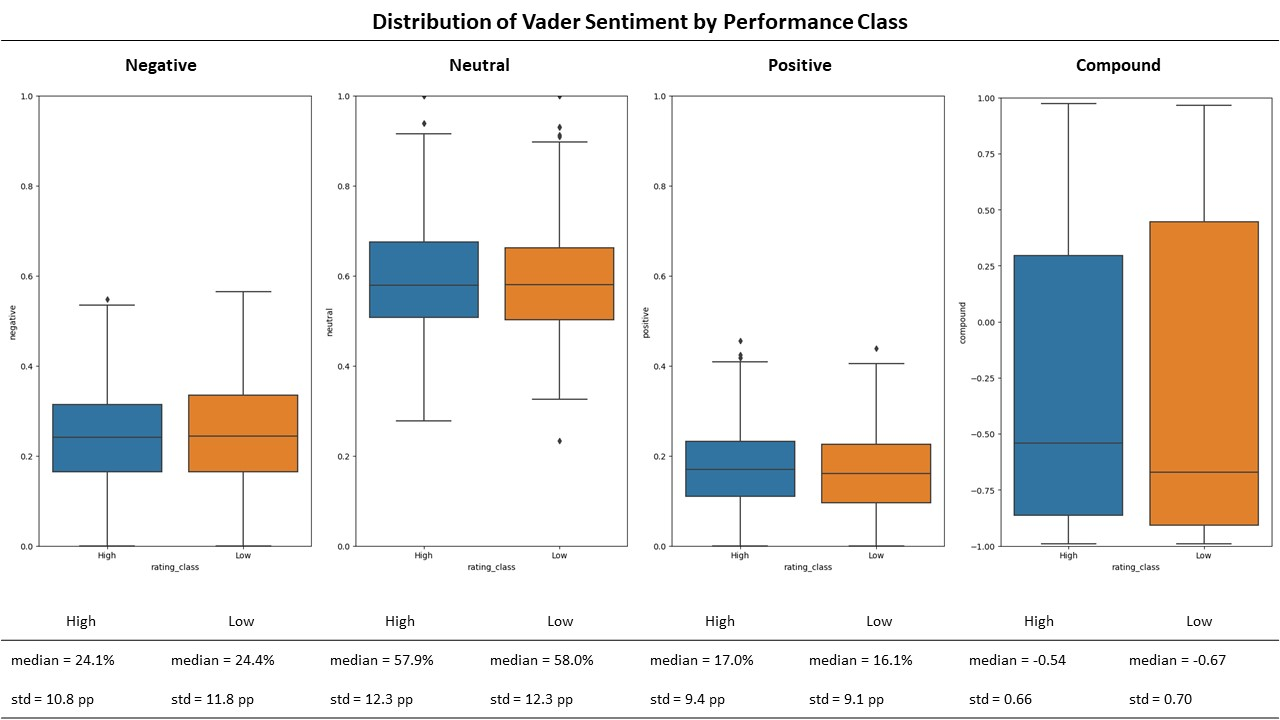

The results of this comparison show that there is no notable variation between the distribution of *Negative* and *Neutral* keywords applied to high performance titles (i.e., those with strong reviews and massive volumes of consumer ratings).

However, the median *Positive* rate among high performance titles is a near percentage point higher, as is the lower bound (25th percentile mark). This suggests the difference between high/low performing titles is that the under-performing titles did not display enough positive sentiment in their descriptions to temper the darkness. This is why Grimdark has anti-heroes after all.

Looking at the *Compound* score results, the median overall sentiment for the high performing titles is 12.8 index points greater than the low. Again, this suggests that while the keywords in overall description of Grimdark novels bend towards the negative, the high performing titles are not extremely negative (i.e., compound = -1), but approximate a median of -0.54.

This implies that with the right amount of negativity/neutrality, there is almost a formula for a proportion of positivity required in each novel description to achieve an overall *sweet spot* Compound sensitivity score (e.g., -0.50 and -0.60). 

But what keywords and topics should be used as building blocks for these tempered descriptions? The following code block begins the examination of keywords extracted using Yake, with the aim of identifying essential novel description elements.

In [ ]:
# fourth: create word frequency tables
def word_frequency(sentence):
    # joins all the sentences
    sentence = " ".join(sentence)
    # creates tokens
    new_tokens = word_tokenize(sentence)
    # counts the words
    counted = Counter(new_tokens)
    # creates and returns a data frame
    word_freq = pd.DataFrame(counted.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
    return word_freq

# plot the frequencies
# high performing
wf_hi = word_frequency(df.desc_yake[df.rating_class == 'High'])
wf_hi.to_csv('wf_hi.csv', index=False)
plt.figure(figsize=(10, 10))
sns.barplot(x='frequency', y='word', data=wf_hi.head(30))
plt.savefig('wf_hi.png', bbox_inches='tight')
plt.show()
# low performing
wf_lo = word_frequency(df.desc_yake[df.rating_class == 'Low'])
wf_lo.to_csv('wf_lo.csv', index=False)
plt.figure(figsize=(10, 10))
sns.barplot(x='frequency', y='word', data=wf_lo.head(30))
plt.savefig('wf_lo.png', bbox_inches='tight')
plt.show()

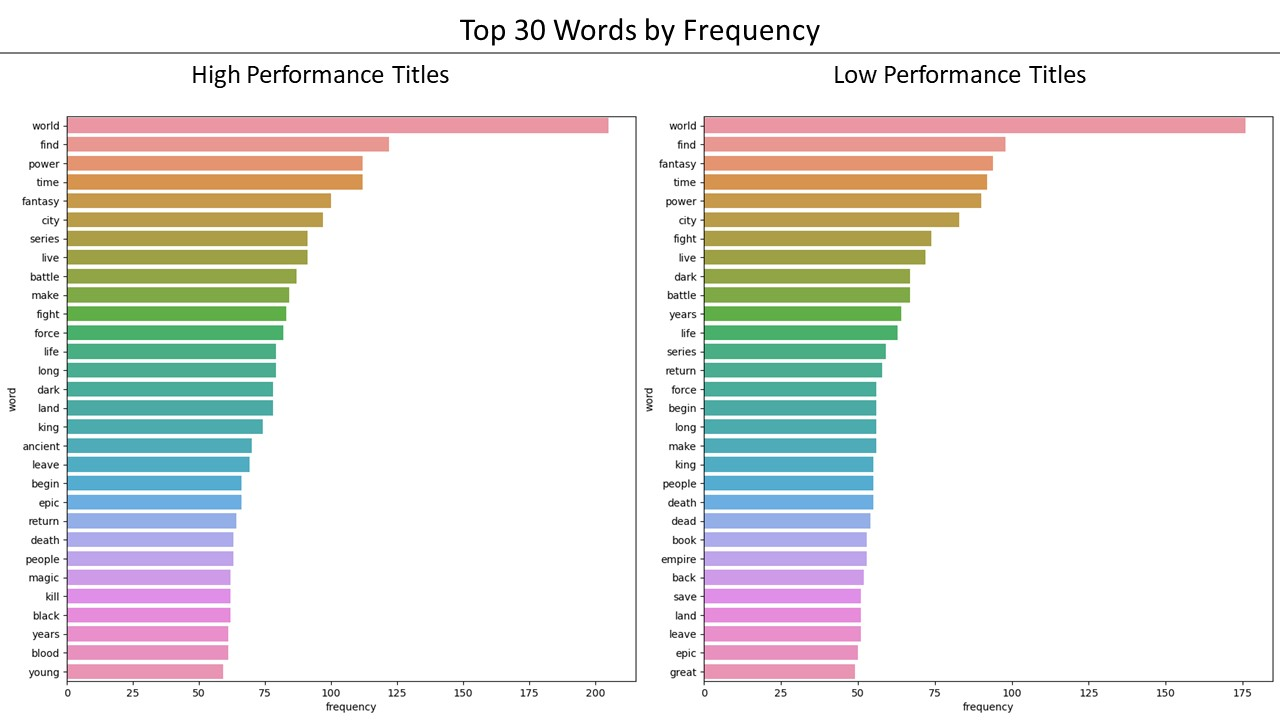

The comparison of the most frequent words above shows there is no cut and dry division of key words/concepts by performance, but that there are a handful of essential topics for the Grimdark genre, plus some specific elements of differentiation. Among the top 5 by frequency, the same terms “world”, “find”, “power”, “time” and “fantasy” rank highest, albeit by a slightly different order. These leading terms represents core concepts of the genre and must be referenced for any potential descriptions to be recognised as Grimdark by potential readers. However what terms differentiate high performing titles? 

The following code block takes this next step to isolate those words unique to high performance titles, as well as those common to both (considered the core building blocks for all Grimdark descriptions) and generates wordclouds by these subpopulations.

In [ ]:
# isolate words only in high performing
common = wf_hi.merge(wf_lo, on=["word"])
common['frequency'] = (common['frequency_x'] + common['frequency_y'])
wf_unique = wf_hi[~wf_hi.word.isin(common.word)]
# fifth: create wordclouds from the high, low, unique and common word frequencies (converted to dicts)
wf_hi_dic = wf_hi.set_index('word').to_dict()['frequency']
wf_lo_dic = wf_lo.set_index('word').to_dict()['frequency']
wf_un_dic = wf_unique.set_index('word').to_dict()['frequency']
wf_co_dic = common.set_index('word').to_dict()['frequency']
# Create High performing
wcHi=WordCloud(width=800,height=400,max_words=100,background_color="white").generate_from_frequencies(wf_hi_dic)
plt.figure()
plt.imshow(wcHi, interpolation="bilinear")
plt.axis("off")
plt.savefig('wc_hi.png', bbox_inches='tight')
plt.show()
# Create Low performing
wcLo=WordCloud(width=800,height=400,max_words=100,background_color="white").generate_from_frequencies(wf_lo_dic)
plt.figure()
plt.imshow(wcLo, interpolation="bilinear")
plt.axis("off")
plt.savefig('wc_lo.png', bbox_inches='tight')
plt.show()
# Create Unique to High
wcUn=WordCloud(width=800,height=400,max_words=100,background_color="white").generate_from_frequencies(wf_un_dic)
plt.figure()
plt.imshow(wcUn, interpolation="bilinear")
plt.axis("off")
plt.savefig('wc_uni.png', bbox_inches='tight')
plt.show()
# Create Common to both
wcCo=WordCloud(width=800,height=400,max_words=100,background_color="white").generate_from_frequencies(wf_co_dic)
plt.figure()
plt.imshow(wcCo, interpolation="bilinear")
plt.axis("off")
plt.savefig('wc_com.png', bbox_inches='tight')
plt.show()

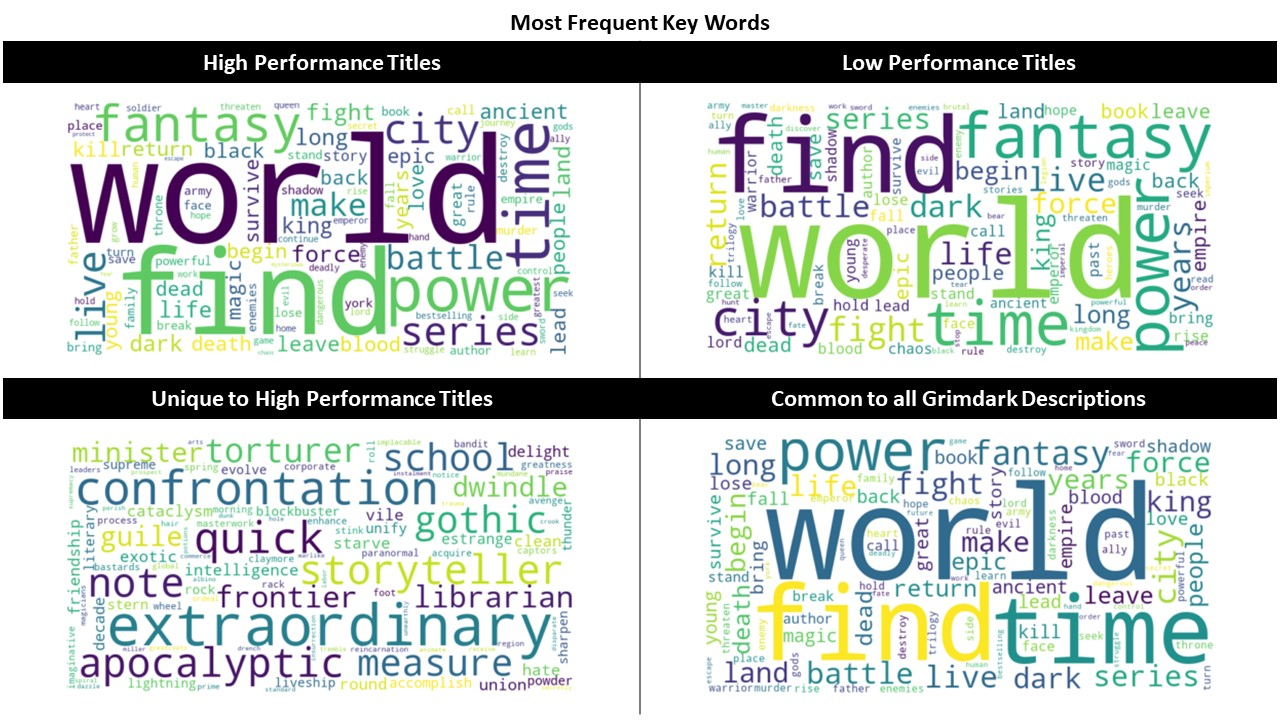

Consistent with prior findings, the top two clouds show there is notable overlap in the terms used across the Genre, however the bottom left shows those terms unique to high performance titles that provide a competitive advantage in developing novel descriptions for the Grimdark audience. Combined with core themes, common to all Grimdark titles (the bottom right cloud), you have the building blocks for promotion success among fantasy novel consumers.

### <u>Summary of Findings</u>

Following the harvesting of data from 25 Goodreads Grimdark shelf pages, supplemented with metadata from the Google Books API, preliminary exploratory data analysis showed that novels from the Fantasy subgenre Grimdark are a median of 416 pages long, with a median description length of 660 characters, and receive a median rating of 4.1 (out of 5) by a median of 2,177 consumers.

When examined by high/low performance classification however, it was found the high-performance titles typically range between 200 and 1,200 pages, with an accompanying description between 400 and 1,800 characters. In fact, the median page length of high performing titles (456 pages) is notably greater than the less well received titles (384 pages), which implied that novels with more depth are received more favourably among Grimdark readers, with high performing outliers even ranging between 1,000 and 1,700 pages.

Following the three phases of NLP processing (i.e., pre-processing, keyword extraction and sentiment analysis), further comparative analysis among high/low performing titles showed no notable variation in novel descriptions among Vader derived rates of Negative/Neutral sentiment, but a marginally elevated rate of Positive sentiment among the more successful titles descriptions. Suggesting that the under-performing titles did not display enough positive sentiment in their descriptions to temper the rate of negativity; they went a little too far.

This was supported by the Vader Compound score, with high performing titles 12.8 index points more positive. Which suggests that while still negative, high performing titles are not extremely negative (i.e., compound = -1), but approximate a median of -0.54; with a sweet spot of between -0.50 and -0.60.

Turning to the keywords and themes extracted with Yake, a comparison between high/low performing titles showed that among Grimdark novel descriptions there is no clear division of concepts/themes by performance, but that a handful of terms are ubiquitous to the subgenre, with some standout keywords identified as unique to high performance titles.

A summary of the “recipe for success” for Grimdark novel descriptions is shown in the following prototype dashboard to allow for easy digestion of results.

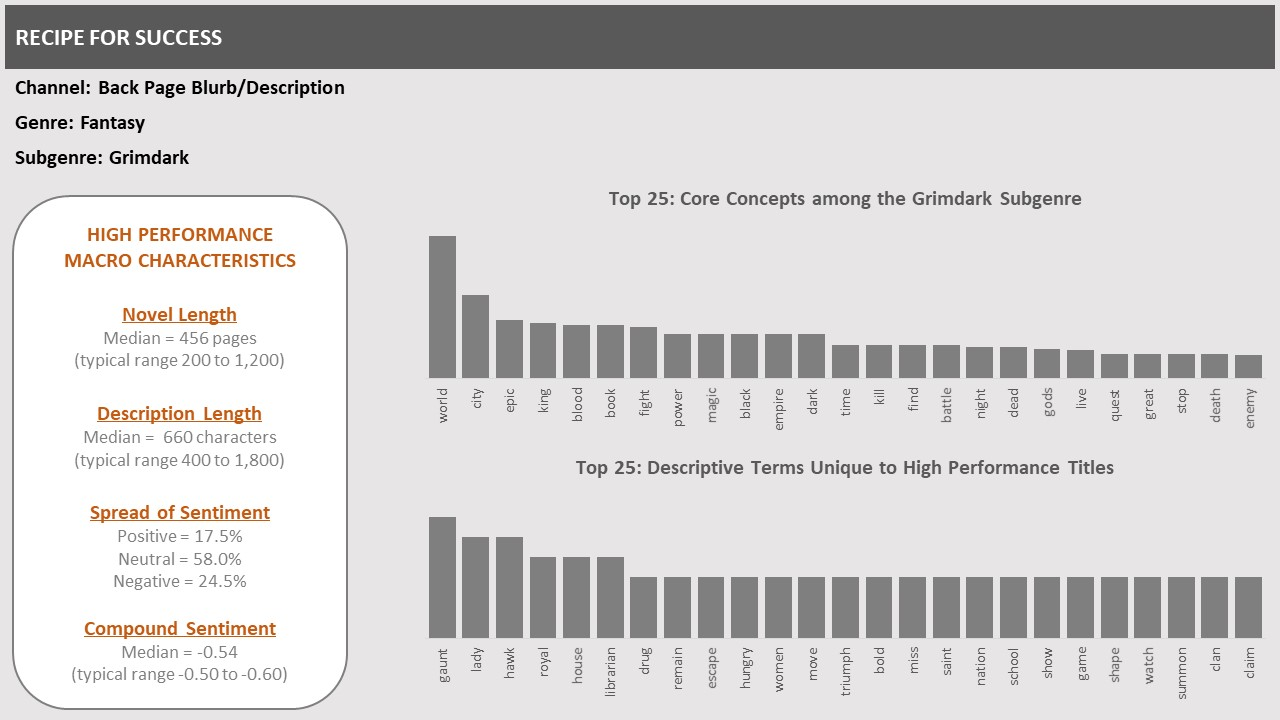

### <u>Further Development Potential</u>

It is assumed that the prototype outlined here is just one piece of a potential product. This potential product could harvest data from any of the Goodreads shelf subgenres given a user input, supplement the resulting titles from Google Books API, conduct data cleansing with defined functions, then pre-process and conduct both NLP analysis to generate a so called “recipe for success” as termed above. 

Using scalable/parallel processing this entire phase could be conducted seamlessly.

But the second half of the product, not covered in this prototype, could be an analysis of a user’s input draft novel description using the same NLP analysis processes used here and contrast the results against the so called “recipe for success”. The contrast could advise the user how much their input description varies from the detected high-performance characteristics. Allowing them to tweak their content until the required core and competitive advantage terms/concepts are present and until the right balance of positive/neutral/negative sentiment is attained. 

### <u>Process Limitations</u>

The process while valid in this prototype example may not always perform to expectations.

Concerning the WebScraper, if the structure or labels used by the Goodreads maintenance team are altered significantly this program may fall over or return no results whatsoever. Further, should Goodreads choose to no longer maintain or drop the “custom bookshelves” legacy system altogether, then scraping the site by subgenre will no longer be feasible and no data will be harvested from this source.

With regard to the Google Books API, this structure is maintained by a reputable secure source, but if there are no titles to search from it, or if the titles scraped have not yet been widely published, no supplementary metadata will be available on them.

And lastly, concerning the NLP systems, if any of the pre-processing, Yake or Vader libraries or their dependencies are dropped from maintenance, version capability issues will snowball and leave the entire process in a heap. Further, as new more powerful and efficient methods emerge the process will need to be updated to match standard CPU capability levels, otherwise the end product will be a glitchy lethargic behemoth that no potential user has the time for.

### <u>References</u>

* Ankit, R. (2021). Python | Sentiment Analysis using VADER. GeeksforGeeks. https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/?ref=lbp


* Bird, S., Klein, E., & Loper, E. (2009). Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit (1st ed.). O’Reilly Media. https://www.nltk.org/book/


* Burchell, J. (2017). Using VADER to handle sentiment analysis with social media text. T-Redactyl. https://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html


* Campos, R., Mangaravite, V., Pasquali, A., Jatowt, A., Jorge, A., Nunes, C. and Jatowt, A. (2020). YAKE! Keyword Extraction from Single Documents using Multiple Local Features. In Information Sciences Journal. Elsevier, Vol 509, pp 257-289


* Campos, R., Mangaravite, V., Pasquali, A., Jorge, A. M., Nunes, C., & Jatowt, A. (2018). A Text Feature Based Automatic Keyword Extraction Method for Single Documents. Lecture Notes in Computer Science, 684–691. https://doi.org/10.1007/978-3-319-76941-7_63


* Chaudhary, A. (2020). Unsupervised Keyphrase Extraction. Chaudhary Research & Engineering. https://amitness.com/keyphrase-extraction/


* Dumas, N. (2015). GitHub - therealfakemoot/collections2: collections2 is a pure-python reimplementation of several collections objects. GitHub. https://github.com/therealfakemoot/collections2


* Hunter, J., & Droettboom, M. (2021). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95. https://pypi.org/project/matplotlib/


* Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014. https://github.com/cjhutto/vaderSentiment


* Kooten, P. (2020). GitHub - kootenpv/contractions: Fixes contractions such as `you’re` to you `are`. GitHub. https://github.com/kootenpv/contractions


* Mayo, M. (2020). A General Approach to Preprocessing Text Data. KDnuggets. https://www.kdnuggets.com/2017/12/general-approach-preprocessing-text-data.html


* Mueller, A. (2020). WordCloud for Python. WordCloud for Python Documentation. https://amueller.github.io/word_cloud/


* Pandey, P. (2020). Simplifying Sentiment Analysis using VADER in Python (on Social Media Text). Medium. https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f


* Rao, P. (2019). Fine-grained Sentiment Analysis in Python (Part 1) - Towards Data Science. Medium. https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4


* Reback, J. (2021). pandas-dev/pandas: Pandas 1.3.4. Zenodo. https://zenodo.org/record/5574486


* Regular expression operations — Python 3.10.0 documentation. (2021). Python Documentation. https://docs.python.org/3/library/re.html


* Richardson, L. (2021). Beautiful Soup: We called him Tortoise because he taught us. BeautifulSoup. https://www.crummy.com/software/BeautifulSoup/


* Shrivastava, I. (2020). Exploring Different Keyword Extractors — Statistical Approaches. Medium. https://medium.com/gumgum-tech/exploring-different-keyword-extractors-statistical-approaches-38580770e282


* Unidecode. (2021). PyPI. https://pypi.org/project/Unidecode/


* Verma, U. (2020). Text Preprocessing for NLP (Natural Language Processing),Beginners to Master. Retrieved from https://medium.com/analytics-vidhya/text-preprocessing-for-nlp-natural-language-processing-beginners-to-master-fd82dfecf95


* Waskom, M. (2021). Seaborn. https://seaborn.pydata.org/


* Weng, J. (2021). NLP Text Preprocessing: A Practical Guide and Template. Medium. https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79


* word2number. (2017). PyPI. https://pypi.org/project/word2number/